In [1]:
# Libraries
import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
# Dataset
df = pd.read_excel('Sentiments.xlsx')

In [3]:
# Preprocessing

# remove sentiments that are not labeled
df = df[df.Sentiment.notnull()]

df.reset_index(drop=True, inplace=True)

df = df[df.Comment.notnull()]

df.reset_index(drop=True, inplace=True)

# In our case, Percentage and Topic columns are not necessary
# Dropping unnecessary columns
df.drop(columns=["Percentage", "Topic"], inplace=True)

df.reset_index(drop=True, inplace=True)

# removing comments those sentiments are undefined
undefined_sentiment_labels = ('Undefined', 'undefined', 'Undefiend', '(?)')
df.drop(df[df['Sentiment'].isin(undefined_sentiment_labels)].index, inplace = True)

df.reset_index(drop=True, inplace=True)

# renaming the positive sentiment labels into one label: 'Postive'
positive_sentiment_labels = ('positive', 'Positive ', 'Postive')
df["Sentiment"] = df["Sentiment"].replace(positive_sentiment_labels, 'Positive')

df.reset_index(drop=True, inplace=True)

# renaming the negative sentiment labels into one label: 'Negative'
negative_sentiment_labels = (' Negative', 'Negativ e', 'negative', ' Neg')
df["Sentiment"] = df["Sentiment"].replace(negative_sentiment_labels, 'Negative')

df.reset_index(drop=True, inplace=True)

# renaming the neutral sentiment labels into one label: 'Neutral'
neutral_sentiment_labels = ('neutral')
df["Sentiment"] = df["Sentiment"].replace(neutral_sentiment_labels, 'Neutral')

df.reset_index(drop=True, inplace=True)

df = df.drop(df[df['Sentiment'] == 'Neutral'].sample(frac=0.33).index)
df.reset_index(drop=True, inplace=True)

In [4]:
print(df['Sentiment'].unique())
print(df.shape)

['Negative' 'Positive' 'Neutral']
(21070, 2)


In [5]:
# Using the pre-built Stemmer for Azerbaijani Language
# Thanks for the efforts of Samir T. Mammadov

# Stemmer class definition
class Stemmer:
    # Stores the words loaded from the words.txt file
    words = set()
    # Stores the suffixes loaded from the suffix.txt file
    suffixes = []
    # Stores all possible stems of a word
    stems = []

    # Constructor of the Stemmer class
    def __init__(self):
        # Loads words from the words.txt file
        self.__load_words()
        # Loads suffixes from the suffix.txt file
        self.__load_suffixes()

    # Destructor of the Stemmer class
    def __del__(self):
        # Clear both lists to free the memory space
        self.words.clear()
        self.suffixes.clear()

    # Loads the words from the word.txt file into memory
    def __load_words(self):
        # Open words.txt file in read mode with utf-8 encoding.
        with open("words.txt", "r", encoding="utf8") as words_file:
            # Iterate over each line in the words.txt file
            for word in words_file:
                # Trim the spaces and newline characters from the string before adding to the list
                self.words.add(word.strip())

    # Loads the suffixes from the suffix.txt file into memory
    def __load_suffixes(self):
        # Open suffix.txt file in read mode with utf-8 encoding
        with open("suffix.txt", "r", encoding="utf8") as suffix_file:
            # Iterate over each line in the suffix.txt file
            for suffix in suffix_file:
                # Trim the spaces and newline characters from the string before adding to the list
                self.suffixes.append(suffix.strip())

    # Removes one suffix at a time
    def suffix(self, word):
        for suffix in self.suffixes:
            # If the word ends with the particular suffix, create a new word by removing that suffix
            if word.endswith(suffix) and (word[:word.rfind(suffix)] in self.words):
                word = word[:word.rfind(suffix)]
                return word
        # Iterate over the suffixes
        for suffix in self.suffixes:
            # If the word ends with the particular suffix, create a new word by removing that suffix
            if word.endswith(suffix):
                word = word[:word.rfind(suffix)]
                return word
        return word

    # Converts changed suffixes and roots to their original forms
    def converter(self, word):
        if word.endswith('lığ') or word.endswith('luğ') or word.endswith('lağ') or word.endswith('cığ'):
            l=list(word); l[-1]='q'; return "".join(l)
        if word.endswith('liy') or word.endswith('lüy'):
            l=list(word); l[-1]='k'; return "".join(l)
        if word.endswith('cağ'):
            l=list(word); l[-1]='q'; return "".join(l)
        if word.endswith('cəy'):
            l=list(word); l[-1]='k'; return "".join(l)
        if word.endswith('ığ') or word.endswith('uğ') or word.endswith('ağ'):
            l=list(word); l[-1]='q'; return "".join(l)
        if word.endswith('iy') or word.endswith('üy') or word.endswith('əy'):
            l=list(word); l[-1]='k'; return "".join(l)
        if word == 'ed':
            l=list(word); l[1]='t'; return "".join(l)
        if word == 'ged':
            l=list(word); l[2]='t'; return "".join(l)
        return word
        
    # Returns the stemmed version of word
    def stem_word(self, word):
        # Change the word to lowercase.
        word = word.lower()
        # Convert if the word has changed root or suffix
        word = self.converter(word)
        # If word is already in the list, append it to stems list
        if word.isnumeric():
                self.stems.append(word)
        else: 
            if word in self.words:
                self.stems.append(word)
        # Iterate through suffixes
        for suffix in self.suffixes:
                # If word ends with current suffix, remove the suffix and stem again
                if word.endswith(suffix):
                    self.stem_word(word[:word.rfind(suffix)])
                
    # Returns the stemmed versions of the given words
    def stem_words(self, list_of_words):
        # Iterate over the range of word indexes
        list_of_stems = []
        for word in list_of_words:
            # Empty the stems list for each word
            self.stems = []
            # Apply stemming to each word in the list.
            self.stem_word(word)
            selected_stem = ""
            # Choose the stem with the maximum length
            for stem in self.stems:
                if len(stem) > len(selected_stem): selected_stem = stem
            # If there is no selected stem for word, append the word itself
            if selected_stem == "":
                selected_stem = word
            # Append the stem of the current word to the list of stems
            list_of_stems.append(selected_stem)
            
        # Return the updated list.
        return list_of_stems

In [6]:
# Preprocessing continues

def remove_punctuation(comment):
    # a function to remove punctuations from the given comment
    
    punctuations = string.punctuation
    for punctuation in punctuations:
        if punctuation in comment:
            comment = comment.replace(punctuation, '')
    comment = comment.replace('-', '')
    return comment


stemmer = Stemmer()
for i in range(df.shape[0]):
    if not isinstance(df.at[i, 'Comment'], str): # check if the comment is a type string
        df.at[i, 'Comment'] = str(df.at[i, 'Comment'])
    
    original_comment = df.at[i, 'Comment']
    comment = original_comment.lower() # lowercasing the comment
    comment = remove_punctuation(comment) # removing punctuations from it
    comment = " ".join(stemmer.stem_words(comment.split())) # stemming the words in it
    df.at[i, 'Comment'] = comment # replacing original comment with preprocessed comment 
    
    # print("Preprocessed Comment:", df.at[i, 'Comment'])
            
    

<AxesSubplot: >

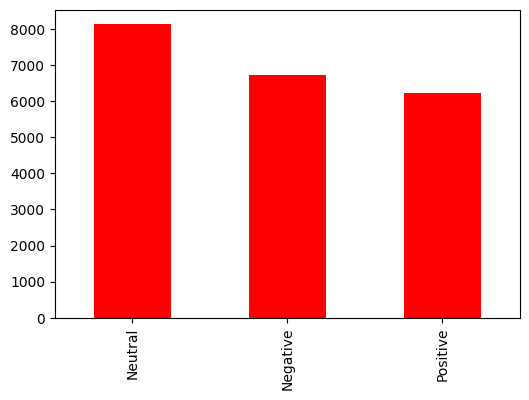

In [7]:
df['Sentiment'].value_counts().plot.bar(color = 'red', figsize = (6, 4))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Sentiment'], test_size=0.2, random_state=42)

In [9]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
# Using X_train and y_train, we create the vocabulary

n = len(X_train) # number_of_sentiments

# vocabulary:
# keys are words, 
# values are a set that contains three elements that are 
# how many times the word appears in positive, negative, and neutral comments
vocabulary = {}

for i in range(n):
    comment = X_train[i]
    sentiment = y_train[i]
    
    if not isinstance(comment, str): # check if the comment is a type string
        comment = str(comment)
        
    for word in comment.split():
        # if word has not been previously seen, add it to the vocabulary with initial value
        if word not in vocabulary:
            vocabulary[word] = [0, 0, 0]
        
        # based on the sentiment value, modify the value of the word key
        if sentiment == 'Positive':
            vocabulary[word][0] += 1
        elif sentiment == 'Negative':
            vocabulary[word][1] += 1
        else:
            vocabulary[word][2] += 1
        
# print(vocabulary)
    

In [11]:
def extract_features(comment):
    total_positives, total_negatives, total_neutrals = 0, 0, 0
    for word in comment:
        if word not in vocabulary:
            continue
        total_positives += vocabulary[word][0]
        total_negatives += vocabulary[word][1]
        total_neutrals += vocabulary[word][2]
    return np.array([1, total_positives, total_negatives, total_neutrals])

In [12]:
X_own = np.zeros((X_train.shape[0], 4)) # initializing X
for i in range(X_train.shape[0]):
    X_own[i, :] = extract_features(X_train[i])
#     print(X[i, :])

X_test_own = np.zeros((X_test.shape[0], 4)) # initializing X_test
for i in range(X_test.shape[0]):
    X_test_own[i, :] = extract_features(X_test[i])


In [ ]:
# Scatter Plot
# x: (sum of the positive frequencies of the words of the comment)
# y: (sum of the negative frequencies of the words of the comment)
# z: (sum of the neutral frequencies of the words of the comment)

X_scatter = pd.DataFrame(X_own[:, 1:], columns=['x', 'y', 'z'])
X_scatter['Sentiment'] = y_train
fig = px.scatter_3d(X_scatter, x='x', y='y', z='z', color='Sentiment')
fig.show()


In [14]:
encoder = preprocessing.LabelEncoder()

print("Model Training using the feature extaction (implemented from scratch)", "\n")

LRC = LogisticRegression(random_state=0, max_iter=200)
LRC.fit(X_own, y_train)

DTC = DecisionTreeClassifier(random_state=0)
DTC.fit(X_own, y_train)

# XGBC = XGBClassifier()
# y_train_xgb = encoder.fit_transform(y_train)
# y_test_xgb = encoder.fit_transform(y_test)
# XGBC.fit(X_own, y_train_xgb)

RFC = RandomForestClassifier()
RFC.fit(X_own, y_train)

MNBC = MultinomialNB(force_alpha=True)
MNBC.fit(X_own, y_train)

y_predicted_LRC = np.empty((y_test.shape[0], 1), dtype=object)
y_predicted_DTC = np.empty((y_test.shape[0], 1), dtype=object)
# y_predicted_XGBC = np.empty((y_test.shape[0], ), dtype=object)
y_predicted_RFC = np.empty((y_test.shape[0], 1), dtype=object)
y_predicted_MNBC = np.empty((y_test.shape[0], 1), dtype=object)

for i in range(len(y_test)):
    y_predicted_LRC[i] = LRC.predict(X_test_own[i].reshape(1, -1))[0]
    y_predicted_DTC[i] = DTC.predict(X_test_own[i].reshape(1, -1))[0]
    # y_predicted_XGBC[i] = XGBC.predict(X_test_own[i].reshape(1, -1))[0]
    y_predicted_RFC[i] = RFC.predict(X_test_own[i].reshape(1, -1))[0]
    y_predicted_MNBC[i] = MNBC.predict(X_test_own[i].reshape(1, -1))[0]

print("(a) Logistic Regression Classifier", "\n")
print("Accuracy:", accuracy_score(y_test, y_predicted_LRC))
print("Calssification Report:", "\n", classification_report(y_test, y_predicted_LRC), "\n")


print("(b) Multionmial Naive Bayes Classifier", "\n")
print("Accuracy:", accuracy_score(y_test, y_predicted_MNBC))
print("Calssification Report:", "\n", classification_report(y_test, y_predicted_MNBC), "\n")


print("(c) Decision Tree Classifier", "\n")
print("Accuracy:",accuracy_score(y_test, y_predicted_DTC))
print("Calssification Report:", "\n", classification_report(y_test, y_predicted_DTC), "\n")

# print("XGBoost Classifier")
# print(accuracy_score(y_test_xgb, y_predicted_XGBC))
# print(classification_report(y_test_xgb, y_predicted_XGBC))

print("(d) Random Forest Classifier", "\n")
print("Accuracy:", accuracy_score(y_test, y_predicted_RFC))
print("Calssification Report:", "\n", classification_report(y_test, y_predicted_RFC), "\n")

Model Training using the feature extaction (implemented from scratch) 

(a) Logistic Regression Classifier 

Accuracy: 0.40389178927384906
Calssification Report: 
               precision    recall  f1-score   support

    Negative       0.43      0.13      0.20      1285
     Neutral       0.40      0.86      0.54      1617
    Positive       0.45      0.11      0.18      1312

    accuracy                           0.40      4214
   macro avg       0.42      0.37      0.31      4214
weighted avg       0.42      0.40      0.32      4214
 

(b) Multionmial Naive Bayes Classifier 

Accuracy: 0.37019458946369244
Calssification Report: 
               precision    recall  f1-score   support

    Negative       0.35      0.40      0.37      1285
     Neutral       0.41      0.28      0.33      1617
    Positive       0.36      0.45      0.40      1312

    accuracy                           0.37      4214
   macro avg       0.37      0.38      0.37      4214
weighted avg       0.38      0.

In [15]:
vectorizer = CountVectorizer()

print("Model Training using CountVectrozier for feature extraction", "\n")
corpus = []
for comment in df['Comment']:
    corpus.append(str(comment))

document_term = vectorizer.fit_transform(corpus)

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(document_term, df['Sentiment'], test_size=0.2, random_state=42)

LRC = LogisticRegression(random_state=0, max_iter=250)
LRC.fit(X_train_cv, y_train_cv)
y_predicted_LRC = LRC.predict(X_test_cv)

print("(a) Logistic Regression Classifier", "\n")
print("Accuracy:",accuracy_score(y_test_cv, y_predicted_LRC))
print("Calssification Report:", "\n", classification_report(y_test_cv, y_predicted_LRC), "\n")


MNBC = MultinomialNB(force_alpha=True)
MNBC.fit(X_train_cv, y_train_cv)
y_predicted_MNBC = MNBC.predict(X_test_cv)

print("(b) Multinomial Naive Bayes Classifier", "\n")
print("Accuracy:",accuracy_score(y_test_cv, y_predicted_MNBC))
print("Calssification Report:", "\n", classification_report(y_test_cv, y_predicted_MNBC), "\n")

DTC = DecisionTreeClassifier(random_state=0)
DTC.fit(X_train_cv, y_train_cv)
y_predicted_DTC = DTC.predict(X_test_cv)

print("(c) Decision Tree Classifier", "\n")
print("Accuracy:",accuracy_score(y_test_cv, y_predicted_DTC))
print("Calssification Report:", "\n", classification_report(y_test_cv, y_predicted_DTC), "\n")


XGBC = XGBClassifier()

y_train_cv_xgb = encoder.fit_transform(y_train_cv)
y_test_cv_xgb = encoder.fit_transform(y_test_cv)

XGBC.fit(X_train_cv, y_train_cv_xgb)

# make predictions on the test data and evaluate the model
y_predicted_XGBC = XGBC.predict(X_test_cv)

print("(d) XGBoost Classifier", "\n")
print("Accuracy:",accuracy_score(y_test_cv_xgb, y_predicted_XGBC))
print("Calssification Report:", "\n", classification_report(y_test_cv_xgb, y_predicted_XGBC), "\n")


RFC = RandomForestClassifier()
RFC.fit(X_train_cv, y_train_cv)

y_predicted_RFC = RFC.predict(X_test_cv)

print("(e) Random Forest Classifier", "\n")
print("Accuracy:",accuracy_score(y_test_cv, y_predicted_RFC))
print("Calssification Report:", "\n", classification_report(y_test_cv, y_predicted_RFC), "\n")

Model Training using CountVectrozier for feature extraction 

(a) Logistic Regression Classifier 

Accuracy: 0.5775984812529663
Calssification Report: 
               precision    recall  f1-score   support

    Negative       0.57      0.50      0.54      1285
     Neutral       0.53      0.64      0.58      1617
    Positive       0.65      0.57      0.61      1312

    accuracy                           0.58      4214
   macro avg       0.59      0.57      0.58      4214
weighted avg       0.58      0.58      0.58      4214
 

(b) Multinomial Naive Bayes Classifier 

Accuracy: 0.5700047460844803
Calssification Report: 
               precision    recall  f1-score   support

    Negative       0.53      0.58      0.55      1285
     Neutral       0.55      0.55      0.55      1617
    Positive       0.65      0.59      0.62      1312

    accuracy                           0.57      4214
   macro avg       0.58      0.57      0.57      4214
weighted avg       0.57      0.57      0.57

In [40]:
test_sentence = "Bu gün yeni öyrənmə səyahətinə başlamaq üçün əla gündür."

# Transform the the sentence
new_document_term = vectorizer.transform([test_sentence])

predicted_label = LRC.predict(new_document_term)

print("Predicted label:", predicted_label[0])


Predicted label: Positive
